In [ ]:
import pandas as pd

df = pd.read_csv('/content/geo_locations_astana_hackathon')
display(df.head())
display(df.info())

,randomized_id,lat,lng,alt,spd,azm
0,7637058049336049989,51.095460,71.427530,350.531020,0.206810,13.601680
1,1259981924615926140,51.098200,71.412950,348.801610,0.000000,265.677000
2,1259981924615926140,51.098460,71.412120,349.273880,4.345010,307.245300
3,7180852955221959108,51.089779,71.428469,314.000000,14.326102,192.123672
4,-6683155579225977143,51.088782,71.417462,325.300018,0.000602,0.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262687 entries, 0 to 1262686
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   randomized_id  1262687 non-null  int64  
 1   lat            1262687 non-null  float64
 2   lng            1262687 non-null  float64
 3   alt            1262687 non-null  float64
 4   spd            1262687 non-null  float64
 5   azm            1262687 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 57.8 MB


None

In [ ]:
import numpy as np
from geopy.distance import geodesic

# Calculate distance for each point based on the previous point for each trip
df['distance'] = df.groupby('randomized_id').apply(
    lambda x: [0] + [geodesic((x.iloc[i-1]['lat'], x.iloc[i-1]['lng']), (x.iloc[i]['lat'], x.iloc[i]['lng'])).meters for i in range(1, len(x))]
).explode().reset_index(drop=True)

# Ensure the distance column is numeric, handling potential errors
df['distance'] = pd.to_numeric(df['distance'], errors='coerce')

# Aggregate features for each trip
df_features = df.groupby('randomized_id').agg(
    avg_spd=('spd', 'mean'),
    spd_std=('spd', 'std'),
    min_spd=('spd', 'min'),
    max_spd=('spd', 'max'),
    avg_alt=('alt', 'mean'),
    alt_std=('alt', 'std'),
    min_alt=('alt', 'min'),
    max_alt=('alt', 'max'),
    avg_azm=('azm', 'mean'),
    azm_std=('azm', 'std'),
    point_count=('randomized_id', 'count'),
    total_distance=('distance', 'sum')
).reset_index()

# Merge df_features with the original df
df_features = pd.merge(df, df_features, on='randomized_id', how='left')

display(df_features.head())
display(df_features.info())

,randomized_id,lat,lng,alt,spd,azm,distance,avg_spd,spd_std,min_spd,max_spd,avg_alt,alt_std,min_alt,max_alt,avg_azm,azm_std,point_count,total_distance
0,7637058049336049989,51.095460,71.427530,350.531020,0.206810,13.601680,0.000000,13.900407,5.105463,1.409500e-01,24.083040,350.181295,1.049324,346.90241,352.980790,182.666637,108.551768,316,1.670672e+05
1,1259981924615926140,51.098200,71.412950,348.801610,0.000000,265.677000,56.815031,7.555007,4.225967,0.000000e+00,18.435410,350.510152,1.092522,348.37082,354.775580,205.144804,98.375560,263,1.449897e+05
2,1259981924615926140,51.098460,71.412120,349.273880,4.345010,307.245300,485.932746,7.555007,4.225967,0.000000e+00,18.435410,350.510152,1.092522,348.37082,354.775580,205.144804,98.375560,263,1.449897e+05
3,7180852955221959108,51.089779,71.428469,314.000000,14.326102,192.123672,919.468714,8.330757,5.861327,5.923145e-19,18.413988,314.775003,5.324609,303.00000,326.500000,156.605713,96.182883,388,2.003519e+05
4,-6683155579225977143,51.088782,71.417462,325.300018,0.000602,0.000000,759.339425,1.217516,2.093904,0.000000e+00,34.225132,328.555113,9.677344,303.10000,367.900024,129.551342,115.300978,4421,2.352945e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262687 entries, 0 to 1262686
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   randomized_id   1262687 non-null  int64  
 1   lat             1262687 non-null  float64
 2   lng             1262687 non-null  float64
 3   alt             1262687 non-null  float64
 4   spd             1262687 non-null  float64
 5   azm             1262687 non-null  float64
 6   distance        1262687 non-null  float64
 7   avg_spd         1262687 non-null  float64
 8   spd_std         1262544 non-null  float64
 9   min_spd         1262687 non-null  float64
 10  max_spd         1262687 non-null  float64
 11  avg_alt         1262687 non-null  float64
 12  alt_std         1262544 non-null  float64
 13  min_alt         1262687 non-null  float64
 14  max_alt         1262687 non-null  float64
 15  avg_azm         1262687 non-null  float64
 16  azm_std         1262544 non-null  fl

None

In [ ]:
# Define the bins for latitude and longitude
lat_bins = np.arange(df_features['lat'].min(), df_features['lat'].max() + 0.005, 0.005)
lng_bins = np.arange(df_features['lng'].min(), df_features['lng'].max() + 0.005, 0.005)

# Create categorical bins for latitude and longitude
df_features['lat_grid'] = pd.cut(df_features['lat'], bins=lat_bins)
df_features['lng_grid'] = pd.cut(df_features['lng'], bins=lng_bins)

# Group by the created zones and calculate aggregate statistics
df_zone_stats = df_features.groupby(['lat_grid', 'lng_grid']).agg(
    zone_avg_spd=('spd', 'mean'),
    zone_spd_std=('spd', 'std'),
    zone_min_spd=('spd', 'min'),
    zone_max_spd=('spd', 'max'),
    zone_avg_alt=('alt', 'mean'),
    zone_alt_std=('alt', 'std'),
    zone_min_alt=('alt', 'min'),
    zone_max_alt=('alt', 'max'),
    zone_avg_azm=('azm', 'mean'),
    zone_azm_std=('azm', 'std'),
    zone_point_count=('randomized_id', 'count'),
    zone_total_distance=('distance', 'sum')
)

# Reset the index to turn zone bins into columns
df_zone_stats = df_zone_stats.reset_index()

# Display the head and info of the resulting DataFrame
display(df_zone_stats.head())
display(df_zone_stats.info())

,lat_grid,lng_grid,zone_avg_spd,zone_spd_std,zone_min_spd,zone_max_spd,zone_avg_alt,zone_alt_std,zone_min_alt,zone_max_alt,zone_avg_azm,zone_azm_std,zone_point_count,zone_total_distance
0,"(51.076, 51.081]","(71.395, 71.4]",21.330518,9.855205,1.436184e+01,28.299200,334.636974,23.811051,317.800018,351.473930,183.028412,242.066859,2,1.712806e+03
1,"(51.076, 51.081]","(71.4, 71.405]",8.491864,3.785375,1.194647e-16,18.436319,316.448377,58.943545,33.890323,354.000000,166.734879,61.022750,231,1.278108e+05
2,"(51.076, 51.081]","(71.405, 71.41]",8.279383,5.180802,-1.000000e+00,21.133556,325.094971,42.745105,33.907784,354.800000,156.831942,74.634667,1153,6.013836e+05
3,"(51.076, 51.081]","(71.41, 71.415]",14.972769,5.398354,0.000000e+00,39.437870,326.488306,16.947937,3.490000,406.000000,178.955137,94.423051,5972,2.969723e+06
4,"(51.076, 51.081]","(71.415, 71.42]",12.012750,6.279786,-1.000000e+00,39.792020,326.116749,17.616949,3.480000,406.600006,160.378397,103.932297,15983,8.142549e+06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   lat_grid             54 non-null     category
 1   lng_grid             54 non-null     category
 2   zone_avg_spd         49 non-null     float64 
 3   zone_spd_std         49 non-null     float64 
 4   zone_min_spd         49 non-null     float64 
 5   zone_max_spd         49 non-null     float64 
 6   zone_avg_alt         49 non-null     float64 
 7   zone_alt_std         49 non-null     float64 
 8   zone_min_alt         49 non-null     float64 
 9   zone_max_alt         49 non-null     float64 
 10  zone_avg_azm         49 non-null     float64 
 11  zone_azm_std         49 non-null     float64 
 12  zone_point_count     54 non-null     int64   
 13  zone_total_distance  54 non-null     float64 
dtypes: category(2), float64(11), int64(1)
memory usage: 6.0 KB


None

In [ ]:
zone_counts = df_features.groupby(['lat_grid', 'lng_grid'])['randomized_id'].nunique().reset_index(name='zone_density')
zone_counts['target'] = np.log1p(zone_counts['zone_density'])
df_zone_target = zone_counts
display(df_zone_target.head())
display(df_zone_target.info())

,lat_grid,lng_grid,zone_density,target
0,"(51.076, 51.081]","(71.395, 71.4]",2,1.098612
1,"(51.076, 51.081]","(71.4, 71.405]",72,4.290459
2,"(51.076, 51.081]","(71.405, 71.41]",78,4.369448
3,"(51.076, 51.081]","(71.41, 71.415]",1110,7.013016
4,"(51.076, 51.081]","(71.415, 71.42]",1516,7.324490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   lat_grid      54 non-null     category
 1   lng_grid      54 non-null     category
 2   zone_density  54 non-null     int64   
 3   target        54 non-null     float64 
dtypes: category(2), float64(1), int64(1)
memory usage: 1.8 KB


None

In [ ]:
df_ml = pd.merge(df_zone_stats, df_zone_target, on=['lat_grid', 'lng_grid'], how='inner')
display(df_ml.head())
display(df_ml.info())

,lat_grid,lng_grid,zone_avg_spd,zone_spd_std,zone_min_spd,zone_max_spd,zone_avg_alt,zone_alt_std,zone_min_alt,zone_max_alt,zone_avg_azm,zone_azm_std,zone_point_count,zone_total_distance,zone_density,target
0,"(51.076, 51.081]","(71.395, 71.4]",21.330518,9.855205,1.436184e+01,28.299200,334.636974,23.811051,317.800018,351.473930,183.028412,242.066859,2,1.712806e+03,2,1.098612
1,"(51.076, 51.081]","(71.4, 71.405]",8.491864,3.785375,1.194647e-16,18.436319,316.448377,58.943545,33.890323,354.000000,166.734879,61.022750,231,1.278108e+05,72,4.290459
2,"(51.076, 51.081]","(71.405, 71.41]",8.279383,5.180802,-1.000000e+00,21.133556,325.094971,42.745105,33.907784,354.800000,156.831942,74.634667,1153,6.013836e+05,78,4.369448
3,"(51.076, 51.081]","(71.41, 71.415]",14.972769,5.398354,0.000000e+00,39.437870,326.488306,16.947937,3.490000,406.000000,178.955137,94.423051,5972,2.969723e+06,1110,7.013016
4,"(51.076, 51.081]","(71.415, 71.42]",12.012750,6.279786,-1.000000e+00,39.792020,326.116749,17.616949,3.480000,406.600006,160.378397,103.932297,15983,8.142549e+06,1516,7.324490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   lat_grid             54 non-null     category
 1   lng_grid             54 non-null     category
 2   zone_avg_spd         49 non-null     float64 
 3   zone_spd_std         49 non-null     float64 
 4   zone_min_spd         49 non-null     float64 
 5   zone_max_spd         49 non-null     float64 
 6   zone_avg_alt         49 non-null     float64 
 7   zone_alt_std         49 non-null     float64 
 8   zone_min_alt         49 non-null     float64 
 9   zone_max_alt         49 non-null     float64 
 10  zone_avg_azm         49 non-null     float64 
 11  zone_azm_std         49 non-null     float64 
 12  zone_point_count     54 non-null     int64   
 13  zone_total_distance  54 non-null     float64 
 14  zone_density         54 non-null     int64   
 15  target               54 n

None

In [ ]:
from sklearn.model_selection import train_test_split

X = df_ml.drop(['lat_grid', 'lng_grid', 'zone_density', 'target'], axis=1)
y = df_ml['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (43, 13)
Shape of X_test: (11, 13)
Shape of y_train: (43,)
Shape of y_test: (11,)


## Обучение модели


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# После обучения модели RandomForestRegressor (как в вашей ячейке cell_id: 3277a668)

# Доступ к отдельным деревьям в лесу
# Каждое дерево является объектом DecisionTreeRegressor
# Пример: доступ к первому дереву
first_tree = model.estimators_[0]
print("Первое дерево в лесу:")
print(first_tree)

# Доступ к важности признаков
# Это показывает, насколько каждый признак был важен для предсказаний модели
feature_importances = model.feature_importances_
feature_names = X_train.columns

importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importances_df = importances_df.sort_values(by='importance', ascending=False)

print("\nВажность признаков:")
display(importances_df)

# Вы также можете посмотреть на параметры, с которыми была обучена модель
print("\nПараметры обученной модели:")
print(model.get_params())

Первое дерево в лесу:
DecisionTreeRegressor(max_features=1.0, random_state=1608637542)

Важность признаков:


,feature,importance
12,predicted_demand,0.570620
10,zone_point_count,0.156480
11,zone_total_distance,0.154287
2,zone_min_spd,0.027845
1,zone_spd_std,0.024231
0,zone_avg_spd,0.022121
7,zone_max_alt,0.014048
3,zone_max_spd,0.011777
5,zone_alt_std,0.006401
6,zone_min_alt,0.003751



Параметры обученной модели:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

model_quality = r2

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

RMSE: 0.789819472969992
R-squared: 0.905783966709124


In [ ]:
df_ml['predicted_demand'] = model.predict(X)
display(df_ml.head())

,lat_grid,lng_grid,zone_avg_spd,zone_spd_std,zone_min_spd,zone_max_spd,zone_avg_alt,zone_alt_std,zone_min_alt,zone_max_alt,zone_avg_azm,zone_azm_std,zone_point_count,zone_total_distance,zone_density,target,predicted_demand
0,"(51.076, 51.081]","(71.395, 71.4]",21.330518,9.855205,1.436184e+01,28.299200,334.636974,23.811051,317.800018,351.473930,183.028412,242.066859,2,1.712806e+03,2,1.098612,1.265124
1,"(51.076, 51.081]","(71.4, 71.405]",8.491864,3.785375,1.194647e-16,18.436319,316.448377,58.943545,33.890323,354.000000,166.734879,61.022750,231,1.278108e+05,72,4.290459,4.005176
2,"(51.076, 51.081]","(71.405, 71.41]",8.279383,5.180802,-1.000000e+00,21.133556,325.094971,42.745105,33.907784,354.800000,156.831942,74.634667,1153,6.013836e+05,78,4.369448,4.168439
3,"(51.076, 51.081]","(71.41, 71.415]",14.972769,5.398354,0.000000e+00,39.437870,326.488306,16.947937,3.490000,406.000000,178.955137,94.423051,5972,2.969723e+06,1110,7.013016,6.284601
4,"(51.076, 51.081]","(71.415, 71.42]",12.012750,6.279786,-1.000000e+00,39.792020,326.116749,17.616949,3.480000,406.600006,160.378397,103.932297,15983,8.142549e+06,1516,7.324490,7.349690


In [ ]:
import numpy as np

# Create a new DataFrame with relevant columns
predictions_df = df_ml[['lat_grid', 'lng_grid', 'zone_avg_alt', 'zone_avg_azm', 'zone_point_count', 'target', 'predicted_demand']].copy()

# Add actual demand by inverse transforming the target
predictions_df['actual_demand'] = np.expm1(predictions_df['target'])

# Calculate priority score (using predicted demand as a starting point)
predictions_df['priority_score'] = predictions_df['predicted_demand']

# Sort the DataFrame by priority score in descending order
predictions_df = predictions_df.sort_values(by='priority_score', ascending=False)

# Display the first few rows
display(predictions_df.head())

,lat_grid,lng_grid,zone_avg_alt,zone_avg_azm,zone_point_count,target,predicted_demand,actual_demand,priority_score
33,"(51.091, 51.096]","(71.425, 71.43]",328.405898,127.906138,94881,8.086410,8.047056,3249.0,8.047056
42,"(51.096, 51.101]","(71.425, 71.43]",327.860745,129.596429,70628,8.005033,7.996696,2995.0,7.996696
38,"(51.096, 51.101]","(71.405, 71.41]",326.685702,123.148518,87740,7.996990,7.994521,2971.0,7.994521
41,"(51.096, 51.101]","(71.42, 71.425]",329.304773,151.563356,60888,7.904335,7.905613,2708.0,7.905613
24,"(51.086, 51.091]","(71.425, 71.43]",327.789788,132.147722,57783,7.724447,7.728750,2262.0,7.728750


In [ ]:
display(df_ml.columns)

Index(['lat_grid', 'lng_grid', 'zone_avg_spd', 'zone_spd_std', 'zone_min_spd',
       'zone_max_spd', 'zone_avg_alt', 'zone_alt_std', 'zone_min_alt',
       'zone_max_alt', 'zone_avg_azm', 'zone_azm_std', 'zone_point_count',
       'zone_total_distance', 'zone_density', 'target', 'predicted_demand'],
      dtype='object')

In [ ]:
import numpy as np

# Create a new DataFrame with relevant columns using the correct column names
predictions_df = df_ml[['lat_grid', 'lng_grid', 'zone_avg_alt', 'zone_avg_azm', 'zone_point_count', 'target', 'predicted_demand']].copy()

# Add actual demand by inverse transforming the target
predictions_df['actual_demand'] = np.expm1(predictions_df['target'])

# Calculate priority score (using predicted demand as a starting point)
predictions_df['priority_score'] = np.expm1(predictions_df['predicted_demand'])

# Sort the DataFrame by priority score in descending order
predictions_df = predictions_df.sort_values(by='priority_score', ascending=False)

# Display the first few rows
display(predictions_df.head())

,lat_grid,lng_grid,zone_avg_alt,zone_avg_azm,zone_point_count,target,predicted_demand,actual_demand,priority_score
33,"(51.091, 51.096]","(71.425, 71.43]",328.405898,127.906138,94881,8.086410,8.047056,3249.0,3123.583878
42,"(51.096, 51.101]","(71.425, 71.43]",327.860745,129.596429,70628,8.005033,7.996696,2995.0,2970.124464
38,"(51.096, 51.101]","(71.405, 71.41]",326.685702,123.148518,87740,7.996990,7.994521,2971.0,2963.669389
41,"(51.096, 51.101]","(71.42, 71.425]",329.304773,151.563356,60888,7.904335,7.905613,2708.0,2711.463738
24,"(51.086, 51.091]","(71.425, 71.43]",327.789788,132.147722,57783,7.724447,7.728750,2262.0,2271.760014


In [ ]:
import folium

# Calculate the central point for each zone by taking the mean of the interval boundaries
predictions_df['lat'] = predictions_df['lat_grid'].apply(lambda x: x.mid).astype(float)
predictions_df['lng'] = predictions_df['lng_grid'].apply(lambda x: x.mid).astype(float)

# Select the top N zones (e.g., top 10)
top_n = 10
top_zones = predictions_df.head(top_n)

# Calculate map center coordinates from the midpoints of the top zones
map_center_lat = top_zones['lat'].mean()
map_center_lng = top_zones['lng'].mean()
m = folium.Map(location=[map_center_lat, map_center_lng], zoom_start=12)

# Add markers for the top zones with tooltips
for index, row in top_zones.iterrows():
    tooltip_text = f"Predicted Demand: {row['priority_score']:.2f}<br>" \
                   f"Actual Demand: {row['actual_demand']:.0f}<br>" \
                   f"Priority Score: {row['priority_score']:.2f}"
    folium.Marker(
        location=[row['lat'], row['lng']],
        tooltip=tooltip_text,  # Use tooltip instead of popup
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)

# Display the map
display(m)

In [ ]:
predictions_df['supply'] = predictions_df['zone_point_count'] / predictions_df['zone_point_count'].mean()
predictions_df['demand_supply_ratio'] = predictions_df['priority_score'] / predictions_df['supply']
predictions_df['demand_supply_difference'] = predictions_df['priority_score'] - predictions_df['supply']
display(predictions_df.head())

,lat_grid,lng_grid,zone_avg_alt,zone_avg_azm,zone_point_count,target,predicted_demand,actual_demand,priority_score,lat,lng,supply,demand_supply_ratio,demand_supply_difference
33,"(51.091, 51.096]","(71.425, 71.43]",328.405898,127.906138,94881,8.086410,8.047056,3249.0,3123.583878,51.0935,71.4275,4.057682,769.795168,3119.526196
42,"(51.096, 51.101]","(71.425, 71.43]",327.860745,129.596429,70628,8.005033,7.996696,2995.0,2970.124464,51.0985,71.4275,3.020478,983.329350,2967.103986
38,"(51.096, 51.101]","(71.405, 71.41]",326.685702,123.148518,87740,7.996990,7.994521,2971.0,2963.669389,51.0985,71.4075,3.752290,789.829564,2959.917099
41,"(51.096, 51.101]","(71.42, 71.425]",329.304773,151.563356,60888,7.904335,7.905613,2708.0,2711.463738,51.0985,71.4225,2.603937,1041.293970,2708.859801
24,"(51.086, 51.091]","(71.425, 71.43]",327.789788,132.147722,57783,7.724447,7.728750,2262.0,2271.760014,51.0885,71.4275,2.471148,919.313476,2269.288865


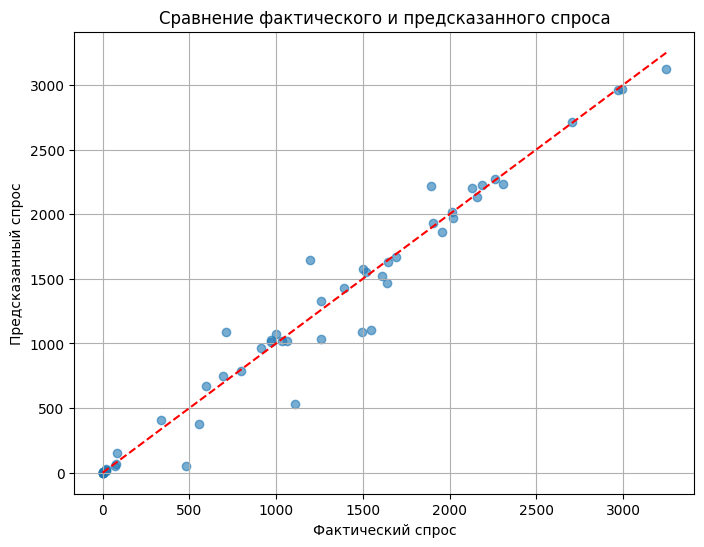

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(predictions_df['actual_demand'], predictions_df['priority_score'], alpha=0.6)
plt.xlabel('Фактический спрос')
plt.ylabel('Предсказанный спрос')
plt.title('Сравнение фактического и предсказанного спроса')
plt.plot([predictions_df['actual_demand'].min(), predictions_df['actual_demand'].max()],
         [predictions_df['actual_demand'].min(), predictions_df['actual_demand'].max()],
         'r--')
plt.grid(True)
plt.show()

In [ ]:
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from folium.plugins import HeatMap

# Calculate the central point for each zone by taking the mean of the interval boundaries
predictions_df['lat'] = predictions_df['lat_grid'].apply(lambda x: x.mid).astype(float)
predictions_df['lng'] = predictions_df['lng_grid'].apply(lambda x: x.mid).astype(float)

# Create a list of points with their demand-supply difference for the heatmap
heat_data = [[row['lat'], row['lng'], row['demand_supply_difference']] for index, row in predictions_df.iterrows()]

# Create a Folium map centered around the average latitude and longitude of the zones
map_center_lat = predictions_df['lat'].mean()
map_center_lng = predictions_df['lng'].mean()
m_heatmap = folium.Map(location=[map_center_lat, map_center_lng], zoom_start=12)

# Add the HeatMap layer to the map
HeatMap(heat_data).add_to(m_heatmap)

# Display the map
display(m_heatmap)

In [ ]:
import numpy as np

# Calculate the absolute error
predictions_df['absolute_error'] = np.abs(predictions_df['actual_demand'] - predictions_df['priority_score'])

# Define quantiles for actual demand
demand_quantiles = predictions_df['actual_demand'].quantile([0.25, 0.5, 0.75])

# Define labels for demand ranges
demand_labels = ['low', 'medium', 'high', 'very high']

# Categorize actual demand into ranges
predictions_df['demand_range'] = pd.cut(predictions_df['actual_demand'], bins=[-np.inf, demand_quantiles[0.25], demand_quantiles[0.5], demand_quantiles[0.75], np.inf], labels=demand_labels, include_lowest=True)

# Group by demand range and calculate the mean absolute error
error_by_demand_range = predictions_df.groupby('demand_range')['absolute_error'].mean()

# Print the mean absolute error for each demand range
print("Mean Absolute Error by Demand Range:")
print(error_by_demand_range)

Mean Absolute Error by Demand Range:
demand_range
low            8.398268
medium       112.659372
high         201.960462
very high     62.421443
Name: absolute_error, dtype: float64


In [ ]:
import joblib

# Define the filename for the saved model
model_filename = 'optimization_model.joblib'

# Save the trained model to the specified file
joblib.dump(model, model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to optimization_model.joblib
